In [38]:
import numpy as np
import pandas as pd
# from easypreprocessing import EasyPreProcessing
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error



Easypreprocessing is a library used for common ML related preprocessing activities.

In [39]:
# prep = EasyPreProcessing('train.csv')
df = pd.read_csv("data/pastInventory.csv")


In [40]:
df.info

<bound method DataFrame.info of      id startOfWeek  chickenOrder  fishOrder  saladOrder
0     1  2024-01-01            44         66          10
1     2  2024-01-08            44         62          14
2     3  2024-01-15            28         77          15
3     4  2024-01-22            33         78           9
4     5  2024-01-29            33         79           8
..  ...         ...           ...        ...         ...
95   96  2025-10-27            31         75          21
96   97  2025-11-03            29         72          19
97   98  2025-11-10            27         77          15
98   99  2025-11-17            21         80          10
99  100  2025-11-24            22         83           5

[100 rows x 5 columns]>

# Handling Null Values

Removing columns that are not helpful for time series predictions.

<Axes: >

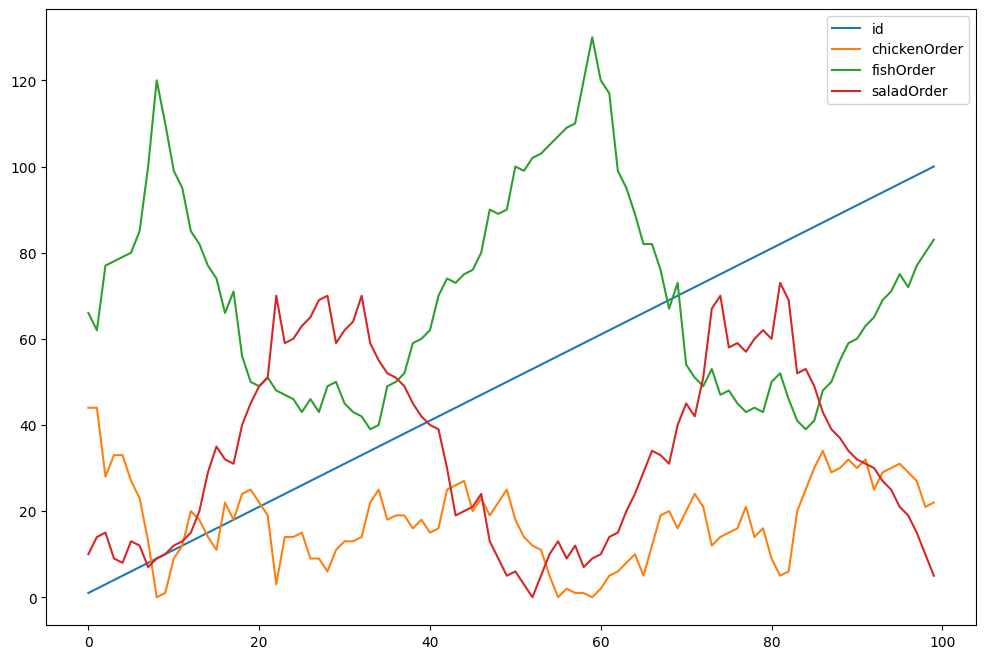

In [41]:
df[:100].plot(figsize=(12,8))

# Converting supervised dataset

Current week's ```chickenOrder```, ```fishOrder```, ```saladOrder```   become target variable

Previous weeks' ```chickenOrder```, ```fishOrder```, ```saladOrder```   becomes input

We will train our model to predict sales based on previous 2 weeks.

In [42]:
df['prev_week_1_co'] = df['chickenOrder'].shift(1)
df['prev_week_1_fo'] = df['fishOrder'].shift(1)
df['prev_week_1_so'] = df['saladOrder'].shift(1)

df['prev_week_2_co'] = df['chickenOrder'].shift(2)
df['prev_week_2_fo'] = df['fishOrder'].shift(2)
df['prev_week_2_so'] = df['saladOrder'].shift(2)

In [6]:
df

,id,startOfWeek,chickenOrder,fishOrder,saladOrder,prev_week_1_co,prev_week_1_fo,prev_week_1_so,prev_week_2_co,prev_week_2_fo,prev_week_2_so
0,1,2024-01-01,21,6,66,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2024-01-08,20,38,62,21.0,6.0,66.0,NaN,NaN,NaN
2,3,2024-01-15,50,64,77,20.0,38.0,62.0,21.0,6.0,66.0
3,4,2024-01-22,32,23,57,50.0,64.0,77.0,20.0,38.0,62.0
4,5,2024-01-29,52,67,76,32.0,23.0,57.0,50.0,64.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...
95,96,2025-10-27,39,53,32,45.0,65.0,1.0,86.0,64.0,90.0
96,97,2025-11-03,52,18,4,39.0,53.0,32.0,45.0,65.0,1.0
97,98,2025-11-10,13,79,17,52.0,18.0,4.0,39.0,53.0,32.0
98,99,2025-11-17,59,27,29,13.0,79.0,17.0,52.0,18.0,4.0


Remove NA data

In [43]:
columns_to_imput = ['prev_week_1_co', 'prev_week_1_fo', 'prev_week_1_so', 'prev_week_2_co', 'prev_week_2_fo', 'prev_week_2_so']

def fill_nan_with_mean_or_default(df, column, default_value=0):
    mean_value = df[column].mean()  # Calculate mean
    if pd.isna(mean_value):  # Check if the mean is NaN
        df[column].fillna(default_value, inplace=True)  # Fill with default value
    else:
        df[column].fillna(mean_value, inplace=True)  # Fill with mean

for col in columns_to_imput: 
    fill_nan_with_mean_or_default(df, col)

/var/folders/m9/trv82rcj1nv8qbl55tlcxdtr0000gn/T/ipykernel_3625/670962727.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(mean_value, inplace=True)  # Fill with mean


In [44]:
df

,id,startOfWeek,chickenOrder,fishOrder,saladOrder,prev_week_1_co,prev_week_1_fo,prev_week_1_so,prev_week_2_co,prev_week_2_fo,prev_week_2_so
0,1,2024-01-01,44,66,10,17.676768,69.868687,34.111111,17.642857,69.765306,34.357143
1,2,2024-01-08,44,62,14,44.000000,66.000000,10.000000,17.642857,69.765306,34.357143
2,3,2024-01-15,28,77,15,44.000000,62.000000,14.000000,44.000000,66.000000,10.000000
3,4,2024-01-22,33,78,9,28.000000,77.000000,15.000000,44.000000,62.000000,14.000000
4,5,2024-01-29,33,79,8,33.000000,78.000000,9.000000,28.000000,77.000000,15.000000
...,...,...,...,...,...,...,...,...,...,...,...
95,96,2025-10-27,31,75,21,30.000000,71.000000,25.000000,29.000000,69.000000,27.000000
96,97,2025-11-03,29,72,19,31.000000,75.000000,21.000000,30.000000,71.000000,25.000000
97,98,2025-11-10,27,77,15,29.000000,72.000000,19.000000,31.000000,75.000000,21.000000
98,99,2025-11-17,21,80,10,27.000000,77.000000,15.000000,29.000000,72.000000,19.000000


<Axes: >

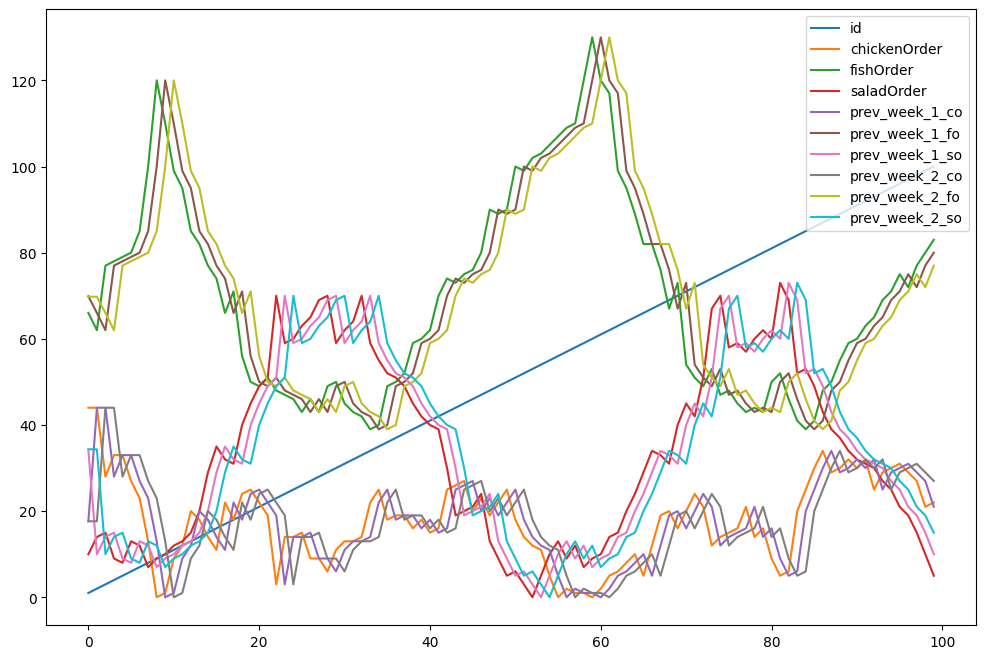

In [45]:
df[:100].plot(figsize=(12,8))

# Train-Test Split

In [46]:
x1, x2, x3, x4, x5, x6, y1, y2, y3 = df['prev_week_1_co'], df['prev_week_1_fo'], df['prev_week_1_so'], df['prev_week_2_co'], df['prev_week_2_fo'], df['prev_week_2_so'], df['chickenOrder'], df['fishOrder'], df['saladOrder']
x1, x2, x3, x4, x5, x6, y1, y2, y3 = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6), np.array(y1), np.array(y2), np.array(y3)
x1, x2, x3, x4, x5, x6, y1, y2, y3 = x1.reshape(-1,1), x2.reshape(-1,1), x3.reshape(-1,1), x4.reshape(-1,1), x5.reshape(-1,1), x6.reshape(-1,1), y1.reshape(-1,1), y2.reshape(-1,1), y3.reshape(-1,1)

X = np.concatenate((x1, x2, x3, x4, x5, x6), axis=1)
y = np.concatenate((y1, y2, y3), axis=1)
# X_train,X_test,y_train,y_test = x[:-test_split],x[-test_split:],y[:-test_split],y[-test_split:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [47]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(80, 6)
(20, 6)
(80, 3)
(20, 3)


# Random Forest Regression

In [48]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor()
model = MultiOutputRegressor(rf_regressor)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [49]:
print(y_pred)

[[  9.47  45.85  62.64]
 [  4.65 104.48   5.88]
 [ 20.21  71.03  41.51]
 [ 22.63  78.63  19.86]
 [ 22.6   73.08  15.78]
 [ 16.97  62.91  45.55]
 [ 18.17  51.12  49.61]
 [ 16.42  44.24  64.12]
 [  2.15 117.68  10.2 ]
 [ 20.03  71.29  33.46]
 [ 19.51  71.91  33.39]
 [ 14.55  49.94  65.76]
 [ 20.01  50.56  50.  ]
 [ 13.8   44.19  64.21]
 [ 28.19  62.76  31.79]
 [ 29.41  81.67   8.92]
 [ 12.64  49.    59.88]
 [ 17.3   44.44  61.86]
 [ 13.58  93.18  11.01]
 [ 14.38  44.63  67.91]]


In [50]:
# for i in range(0, y.shape[1]):
    # print(y_pred[:, i])
    # print( y_test[:, i])
    # print("Mean square score for Random Forest Regression :", model.score(y_pred[:, i], y_test[:, i]))
print("Mean square score for Random Forest Regression :", model.score(X_test, y_test))

Mean square score for Random Forest Regression : 0.6304190930682235


In [51]:
import joblib
joblib.dump(model, 'random_forest_model.joblib')

['random_forest_model.joblib']

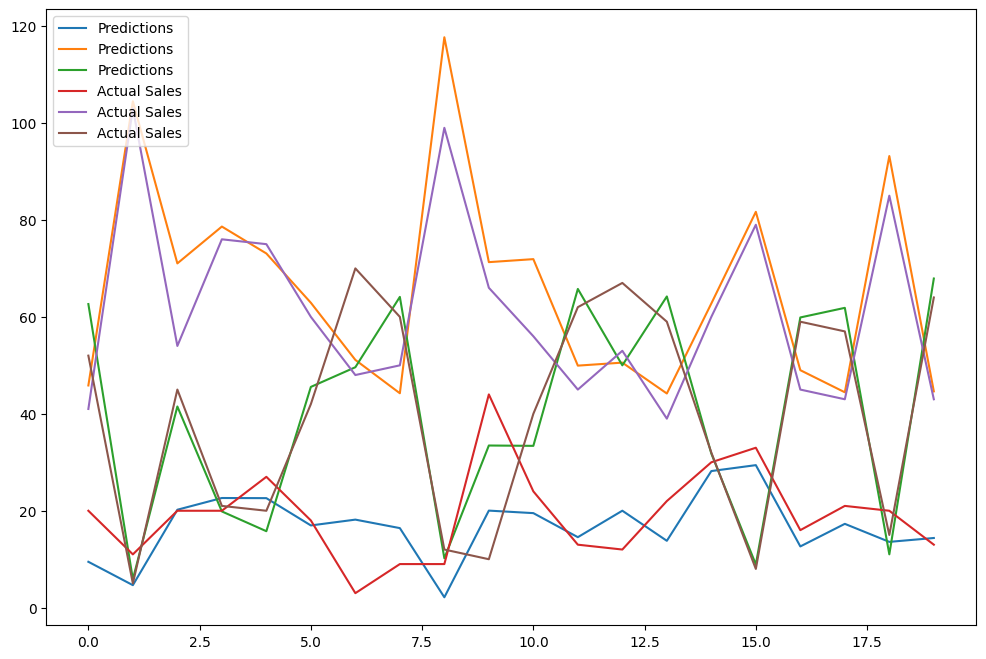

In [52]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(y_pred[-100:], label='Predictions')
plt.plot(y_test[-100:], label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

# Hyperparameter Tuning for Random Forest

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 250, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(0, 120, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 72, 94, 116, 138, 161, 183, 205, 227, 250], 'max_features': ['auto', 'sqrt'], 'max_depth': [0, 6, 12, 18, 25, 31, 37, 44, 50, 56, 63, 69, 75, 82, 88, 94, 101, 107, 113, 120, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [54]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=0, n_jobs = -1)

In [55]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[CV] END bootstrap=True, max_depth=56, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=116; total time=   0.0s
[CV] END bootstrap=True, max_depth=88, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=205; total time=   0.0s[CV] END bootstrap=True, max_depth=88, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=205; total time=   0.0s

[CV] END bootstrap=True, max_depth=94, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=94; total time=   0.0s
[CV] END bootstrap=True, max_depth=88, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=205; total time=   0.0s
[CV] END bootstrap=True, max_depth=94, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=94; total time=   0.0s
[CV] END bootstrap=True, max_depth=56, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=116; total time=   0.0s
[CV] END bootstrap=True, max_depth=94, max_feat

/Users/rubynguyen/venv-tfmetal/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
21 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rubynguyen/venv-tfmetal/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rubynguyen/venv-tfmetal/lib/python3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/rubynguyen/venv-tfmetal/lib/python3.9/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [0, 6, 12, 18, 25, 31, 37,
                                                      44, 50, 56, 63, 69, 75,
                                                      82, 88, 94, 101, 107, 113,
                                                      120, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 72, 94, 116, 138,
                                                         161, 183, 205, 227,
                                                         250]},
                   random_state=0, verbose=2)

In [56]:
rf_random.best_params_

{'n_estimators': 116,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 31,
 'bootstrap': True}

In [57]:
best_random = rf_random.best_estimator_

In [58]:
y_pred = best_random.predict(X_test)

In [59]:
print("R Sq. Score for Random Forest Regression :", best_random.score(X_test, y_test))
print("Adj. R Sq. Score for Random Forest Regression :", 1 - (1 - best_random.score(X_test, y_test) ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 ))

R Sq. Score for Random Forest Regression : 0.6242294310623898
Adj. R Sq. Score for Random Forest Regression : 0.4507968607834928


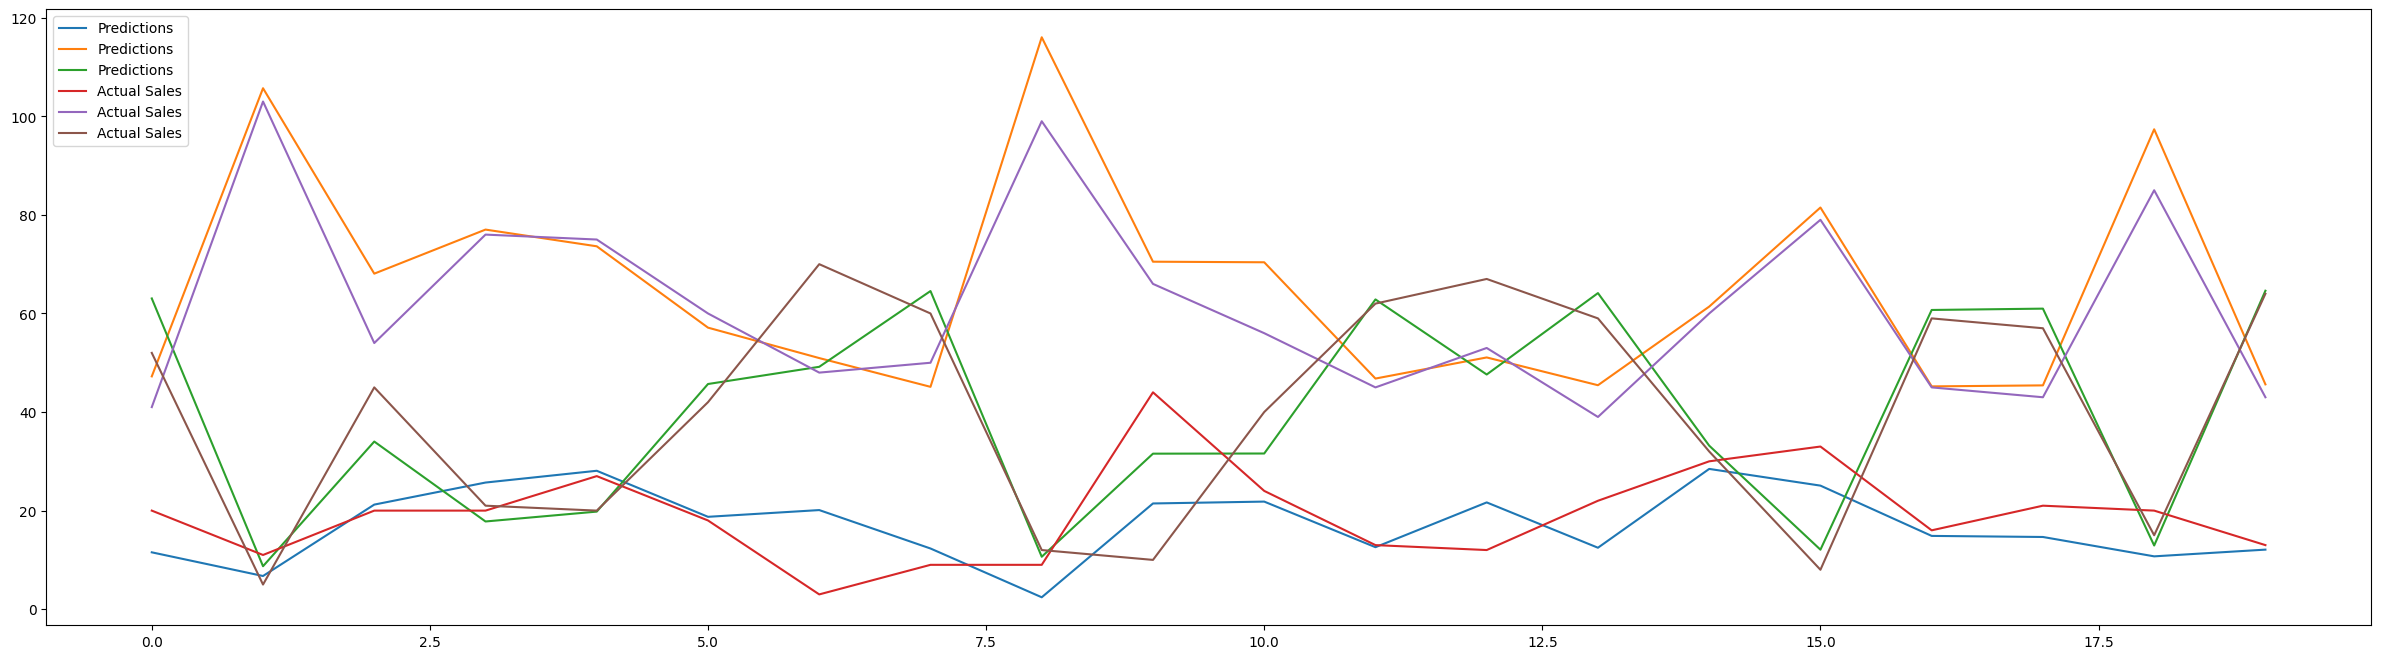

In [60]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,8)
plt.plot(y_pred[:100], label='Predictions')
plt.plot(y_test[:100], label='Actual Sales')
plt.legend(loc="upper left")
plt.savefig('final.png')
plt.show()